# Imports

In [9]:
import gc 
import re 
import scipy
import numpy as np
import pandas as pd
from scipy import sparse
from pprint import pprint
from lightgbm import LGBMRegressor
from IPython.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings; warnings.filterwarnings("ignore")

pd.options.display.max_colwidth=300

ModuleNotFoundError: No module named 'lightgbm'

# Training data 

## Convert the label to SUM of all toxic labels (This might help with maintaining toxicity order of comments)

In [ ]:
df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
print(df.shape)
for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(f'****** {col} *******')
    display(df.loc[df[col]==1,['comment_text',col]].sample(10))

(159571, 8)
****** toxic *******


,comment_text,toxic
98436,"FUCK YOU \n\nI MOTHERFUCKING HAVE BEEN TRYING TO TALK TO YOU AND ALL YOU DO IS DELETE MY COMMENTS. FUCK YOU, DON'T TOUCH MY TALK PAGE.",1
113744,"hELLO, TIPTOY, I HOPE YOU DIE. YOU ARE BEING SUCH A FREAKIN JEW, AND PLEASE, PLEASE GET OFF YOUR FATASS AND STOP MASTURBATING, BECAUSE ITS REALLY GETTING BAD. THE SEMINAL FLUID IS EVERYWHERE, BUT THEN AGAIN, I GUESS YOU LIKE IT THAT WAY, YOU FATASS MOTHER F****ER. GET A F***ING LIFE, AND GO FUCK...",1
36079,"""\nNo. You are quite blatantly the troll here, and the others who have pointed this out, including user:Egg Centric, are right. As I mentioned before, there is no place on wikipedia for """"TheIrishWarden"""". You may have fooled some of us, but you won't get away with this for long! 94.2.68.11 """,1
123987,"Pissed of Nigger + A lot of computers in my school = A lotta Vadalizm \n\nHa... ya can suck my dick, I told ya nigga ta unblock me but you didn't so know ya ganna pay anyone who banned me in the past is ganna get fuked over HARD!",1
12359,Do you think I give a shit? 201.215.187.159,1
17417,"""\n\nAnd something else, """"I, too, don't like the Orthodox priests with their long beards and black robes. I used to have NIGHTMARES when I was little."""" well, I used to have nightmares when I was little too. I was dreaming that the muslim priest is gonna come and cut my dick. What a civilized r...",1
149285,U iz a bitch.\n\n-Donny's Mom,1
79596,"This culture allows people to hold their wives hostage for their dowry, burn them to death, and then remarry more young women from the same family so they can do it all over again. These people consider marriage a form of hostage-taking and have not the slightest shred of common morality, and y...",1
46155,"So fuck off and die, rape fantasising sluts",1
72315,how about you unlock it you virgin losers\noh yeah u mad,1


****** severe_toxic *******


,comment_text,severe_toxic
115551,another noob \n\nfuck u,1
156437,HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAG...,1
69096,How about you go fuck yourself you cunt...,1
31232,"""\n\nYou are too forward; you came onto me too hard. Therefore, Fuck You.\n\n /""""\\n |\./|\n | |\n | |\n |>~<|\n | |\n /'\| |/'\..\n /~\| | ...",1
150609,hey bitch \n\nyou are THE biggest faggot ever! i know you like that cock in ypur ass and all but do you even feel it anymore or is it like throwing a hotdog down a hallway? oh yeah by the way your aunt just called she says she wants you out of her basement and she wants you to get a real job you...,1
26322,"""\n\nWhat the hell asshole!!! Your going to block me for putting the right information on Of Mice & Men (band) artical!! What the fuck!! That's wrong man!! You sir, are an asshole. You are disrespectful to this site and yourself. I have never seen a disgrace in my life. Of Mice & Men are NOT a n...",1
37421,"GO FUCK YOUR SELF , WIKIADMINS",1
64792,"Hello Dreadstar\nYou left a comment on my talk page about uncivil comments. I just wanted to let you know I've seen the err of my ways and have come here to rectify the mistake I made by not also personally attacking you, yourself. So I'd just like to take this opportunity to say suck my dirty a...",1
33886,Fuck you you stupid and gay bastard who thinls you are cool. Go to hell!,1
22378,I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck niggas! I fuck nigg...,1


****** obscene *******


,comment_text,obscene
105758,Please ban me already. I have no interest in this stupid pedia. Not an encyclopedia anyways,1
87138,"You continue to be \n\nA biased, anti-Israel, anti-Semitic piece of s*** who abuses their power here in order to support others just like you. What an asshole you are. Wikipedia must be the only life you have. Get a life, loser! If you continue abusing your power, we will F*** your S*** up. ...",1
80702,"Go ahead and block the IP, cocksucker, I could care less. I don't live in this shitty little country and it seems to me that half the country uses CAT, so go ahead. You pandering git.",1
22633,Flowers is just some backup characters she has nothing to do with whoever Ramona is. Just add Season 2 please seriously if you don't know 2-4 months from now you're gonna feel like a dumbass like you are.,1
84302,OMG\n\nI thought the last freak was a fucking nerd but you take the cake.,1
21024,Fuck off animal shagger.,1
238,u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie,1
59279,"JEW \n\nGet the fuck out of here you jewish son of a bitch, I'll rape your fucking family if you don't leave you semite bastard. I will shoot you if you return, because you're a dirty semite, I hope you choke on a fucking bagel, prick. Shalom. We Came In?",1
147623,Go fuck yourself you stupid cunt 211.29.171.149,1
94046,"""\n\nPaki bastard. — Preceding unsigned comment added by 81.159.129.131 """,1


****** threat *******


,comment_text,threat
62451,"you stupid cunt. (Oh, and I fucked your mother last night. I hope you die.",1
79,Hi! I am back again!\nLast warning!\nStop undoing my edits or die!,1
47648,8=====D- - - \n8=====D- - - -\n8======D- - - \n8=====D- - - \n8========D- - - \n8=======D- - - -\n8=====D- - - - -\n8=======D- - - -\n\nI hope you liberal faggots die and go to hell! Barack Obama 2008!,1
145551,I'm going to start killing these assholes. Chin chin.,1
87043,- Do it and I will cut you,1
72099,You are such a fucking hypocrite. \n\nI hope you get raped and killed by some lunatic like Andrew Morrow.,1
93932,keep this shit up one day something bad will happen to you. yes this is a threat,1
52727,I'M GONNA KILL YOU!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! \n\nI'M GONNA KILL YOU!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,1
88460,"SHUT yOUR bUTT \n\nThats right, i siad it. I hate yuo and i wish yuo wood die.",1
147725,"That may be the case, but there is still no ambiguity over the repulsiveness of irish nationalists, who deserved to be shot dead. 79.75.141.101",1


****** insult *******


,comment_text,insult
50411,"""\n\n RE: \n\nGet a fuckin' job, dude. Most all these I upped before you little trolls starting bitching about pointless rationale, I barely edit shit anymore cuz of you faggots, so block me and """"make your point"""". Do you not realize this is the most pointless shit in human history? """"You can't...",1
7302,", oh shit, stop making warnings, motherfucker, also, fuck you.",1
28027,"You \n\nAre a pompous, juvenile, self-aggrandizing fucking SPIC, and that's all you are.",1
144823,"You Dick \n\nYou're a big, anti-Japanese dick, you know that? I think you should be given an indefinite ban. That's what you should get, an indefinite ban!",1
73764,"Shut up \n\nGet out of my life, i'll do whatever i want bitch.",1
72225,David \n\nWhy are you such a bitch?,1
63190,"=why are you being so rude? i only want to help you motherfuckers. fuck! retards! you're such retards! i hope you all die! seriously, die!!!",1
150022,"I'm in a school you bitch fuck. I have like 20 computers. If you want a war you spic, you've got it.",1
43127,eat shit an die faggot.,1
73692,"Hey Harry, You are a fucking fag. There is nothing wrong with that. You delete all my edits because you know they are correct but are much smarter than anything you can come up with. Ps, you're a cunt. 144.132.144.57",1


****** identity_hate *******


,comment_text,identity_hate
6212,"fuck your couch, nigger!",1
107096,You Cunt \nGo fuck yourself you piece of shit. Don't make me tea beg your mama you faggot!!!,1
8531,Hey queer Andrew\n\nStop messing around!Is your mum lesbian and father homosexual?,1
61934,"orders\n\nDreamjerk has no right to order anyone to do anything. He is one of the more hated \nmembers of Wikipedia. Opponents just go on and do what you need to do.\n\nDaggers in back of Jack the Ripper, lubed by butter, falling on Rhobite.\n\nYou wanna play, we can play.\n\nButterknife.\n\n+++...",1
159033,Shut up you faggot. 4 July 2005 01:23 (UTC),1
76454,Communists \n\nAll communists should be shot as traitors. Starting with you.,1
145498,YOUR VERY DEEPLY OFFENDED! man you sound like a blow-jobbin' old lady. In fact you are a homosexual blow-jobbin' old lady!,1
102896,Get fucked you Dutch cunt.,1
57798,"You are a fag! Why did you deleate Dogatro? It said UNDER CONTRUCTION, Dick!!!!",1
28622,"""\n\n You have no life or friends and all the other admin.s laugh about you behind your back \n\n The Award of the Arabian Barnstar I hereby award you with the Award of the Gay Barnstar due to your incredible gayness and lack of having a life or friends, والسلام عليكم""",1


In [ ]:
df['severe_toxic'] = df.severe_toxic * 2
df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) ).astype(int)
df['y'] = df['y']/df['y'].max()
df = df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})
df.sample(5)

,text,y
158511,"NAVS says: \nIf Mason disagrees, I guess we have conflicting sources. Is it possible that there are some old copies of these editions somewhere?",0.000000
89988,Fucktard \n\nYou are a big fucktard.,0.714286
85257,All you succeeded in doing by your latest post is to convince me that you're not someone with whom reasonable debate can be carried on. I think I can say the same thing. Sunborn over and out.,0.000000
66112,""" —Preceding unsigned comment added by 109.113.46.96 """,0.000000
138124,"""\n\n Mixins - yes or no \n\nThe """"mixins"""" section seems contradictory. In one sentence is says Sass doesn't support mixins, and then goes on to describe Sass mixins and show their syntax. Someone who understands what it really supports needs to clarify this paragraph. ჷTalk """,0.000000


In [ ]:
df['y'].value_counts()

0.000000    143346
0.142857      6360
0.428571      4064
0.285714      3439
0.714286      1064
0.571429       938
0.857143       329
1.000000        31
Name: y, dtype: int64

## Create 3 versions of the data

In [ ]:
n_folds = 7
frac_1 = 0.4
frac_1_factor = 1.5
for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))
    tmp_df.to_csv(f'/kaggle/working/df_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(16225, 2)
0.000000    9735
0.142857    2556
0.428571    1602
0.285714    1382
0.714286     405
0.571429     387
0.857143     142
1.000000      16
Name: y, dtype: int64
Fold: 1
(16225, 2)
0.000000    9735
0.142857    2561
0.428571    1618
0.285714    1384
0.714286     417
0.571429     360
0.857143     141
1.000000       9
Name: y, dtype: int64
Fold: 2
(16225, 2)
0.000000    9735
0.142857    2505
0.428571    1655
0.285714    1412
0.714286     411
0.571429     364
0.857143     132
1.000000      11
Name: y, dtype: int64
Fold: 3
(16225, 2)
0.000000    9735
0.142857    2554
0.428571    1646
0.285714    1377
0.714286     401
0.571429     369
0.857143     133
1.000000      10
Name: y, dtype: int64
Fold: 4
(16225, 2)
0.000000    9735
0.142857    2518
0.428571    1662
0.285714    1374
0.714286     421
0.571429     381
0.857143     125
1.000000       9
Name: y, dtype: int64
Fold: 5
(16225, 2)
0.000000    9735
0.142857    2610
0.428571    1585
0.285714    1370
0.714286     420
0.571429   

# Create 3 versions of __clean__ data

In [ ]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text): return [lemmatizer.lemmatize(w) for w in text]

def clean(data, col):    
    data[col] = data[col].str.replace(r"what's", "what is ")    
    data[col] = data[col].str.replace(r"\'ve", " have ")
    data[col] = data[col].str.replace(r"can't", "cannot ")
    data[col] = data[col].str.replace(r"n't", " not ")
    data[col] = data[col].str.replace(r"i'm", "i am ")
    data[col] = data[col].str.replace(r"\'re", " are ")
    data[col] = data[col].str.replace(r"\'d", " would ")
    data[col] = data[col].str.replace(r"\'ll", " will ")
    data[col] = data[col].str.replace(r"\'scuse", " excuse ")
    data[col] = data[col].str.replace(r"\'s", " ")
    data[col] = data[col].str.replace('\n', ' \n ')
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')    
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    return data

In [ ]:
test_clean_df = pd.DataFrame({"text":
                              ["heyy\n\nkkdsfj",
                               "hi   how/are/you ???",
                               "hey?????",
                               "noooo!!!!!!!!!   comeone !! ",
                              "cooooooooool     brooooooooooo  coool brooo",
                              "naaaahhhhhhh"]})
display(test_clean_df)
clean(test_clean_df,'text')

,text
0,heyy\n\nkkdsfj
1,hi how/are/you ???
2,hey?????
3,noooo!!!!!!!!! comeone !!
4,cooooooooool brooooooooooo coool brooo
5,naaaahhhhhhh


,text
0,heyy kkdsfj
1,hi / are/you ???
2,hey ???
3,noo !!! comeone !!
4,coool broo coool broo
5,naaahh


In [ ]:
df = clean(df,'text')

In [ ]:
df[df.y==0]

,text,y
0,"Explanation Why edits made username Hardcore Metallica Fan reverted ? They vandalisms, closure GAs I voted New York Dolls FAC. And please remove template talk page since I ' retired now.89.205.38.27",0.0
1,"D ' aww ! He matches background colour I ' seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0.0
2,"Hey man, I ' really trying edit war. It guy constantly removing relevant information talking edits instead talk page. He seems care formatting actual info.",0.0
3,""" More I cannot make real suggestions improvement - I wondered section statistics later on, subsection """"types accidents"""" -I think references may need tidying exact format ie date format etc. I later on, no-one else first - preferences formatting style references want please let know. There app...",0.0
4,"You, sir, hero. Any chance remember page ?",0.0
...,...,...
159566,""":::::And second time asking, view completely contradicts coverage reliable sources, anyone care feel ? You cannot even give consistent argument - opening supposed mention significant aspects, """"most significant"""" ones ? """,0.0
159567,You ashamed That horrible thing put talk page. 128.61.19.93,0.0
159568,"Spitzer Umm, theres actual article prostitution ring. - Crunch Captain.",0.0
159569,And looks like actually put speedy first version deleted I look it.,0.0


In [ ]:
n_folds = 7
frac_1 = 0.3
frac_1_factor = 1.2
for fld in range(n_folds):
    tmp_df = pd.concat([df[df.y>0].sample(frac=frac_1, random_state = 10*(fld+1)) , df[df.y==0].sample(n=int(len(df[df.y>0])*frac_1*frac_1_factor) , random_state = 10*(fld+1))], axis=0).sample(frac=1, random_state = 10*(fld+1))
    tmp_df.to_csv(f'/kaggle/working/df_clean_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

(10709, 2)
0.000000    5841
0.142857    1903
0.428571    1208
0.285714    1032
0.714286     307
0.571429     294
0.857143     111
1.000000      13
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1933
0.428571    1222
0.285714    1029
0.714286     318
0.571429     262
0.857143      96
1.000000       8
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1870
0.428571    1233
0.285714    1074
0.714286     306
0.571429     278
0.857143      98
1.000000       9
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1919
0.428571    1231
0.285714    1047
0.714286     298
0.571429     263
0.857143     104
1.000000       6
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1874
0.428571    1261
0.285714    1011
0.714286     329
0.571429     292
0.857143      93
1.000000       8
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1936
0.428571    1181
0.285714    1039
0.714286     330
0.571429     265
0.857143     109
1.000000       8
Name: y,

In [ ]:
del df,tmp_df
gc.collect()

42

## Ruddit data

(5838, 5)


<AxesSubplot:>

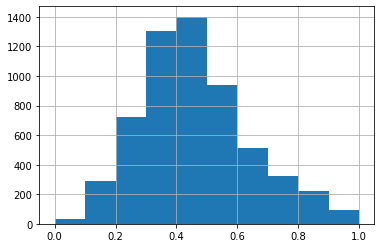

In [ ]:
df_ = pd.read_csv("../input/ruddit-jigsaw-dataset/Dataset/ruddit_with_text.csv")
print(df_.shape)
df_ = df_[['txt', 'offensiveness_score']].rename(columns={'txt': 'text','offensiveness_score':'y'})
df_['y'] = (df_['y'] - df_.y.min()) / (df_.y.max() - df_.y.min()) 
df_.y.hist()

# Create 3 versions of data

In [ ]:
n_folds = 7
frac_1 = 0.7
for fld in range(n_folds):
    print(f'Fold: {fld}')
    tmp_df = df_.sample(frac=frac_1, random_state = 10*(fld+1))
    tmp_df.to_csv(f'/kaggle/working/df2_fld{fld}.csv', index=False)
    print(tmp_df.shape)
    print(tmp_df['y'].value_counts())

Fold: 0
(4087, 2)
0.464668    125
0.475910    106
0.375268     94
0.442719     92
0.364561     89
           ... 
0.400964      1
0.889722      1
0.582976      1
0.404711      1
0.761242      1
Name: y, Length: 268, dtype: int64
Fold: 1
(4087, 2)
0.464668    107
0.475910    103
0.408994    102
0.386510     97
0.364561     88
           ... 
0.851713      1
0.859743      1
0.051927      1
0.666488      1
0.594754      1
Name: y, Length: 264, dtype: int64
Fold: 2
(4087, 2)
0.464668    118
0.475910    102
0.386510     94
0.442719     92
0.364561     89
           ... 
0.261777      1
0.238223      1
0.123126      1
0.694861      1
0.309422      1
Name: y, Length: 265, dtype: int64
Fold: 3
(4087, 2)
0.464668    116
0.475910    106
0.386510     93
0.408994     92
0.364561     90
           ... 
0.238223      1
0.561028      1
0.404711      1
0.806210      1
0.184154      1
Name: y, Length: 263, dtype: int64
Fold: 4
(4087, 2)
0.464668    122
0.475910    114
0.386510    100
0.442719     91
0.

In [ ]:
del tmp_df, df_; 
gc.collect()

42

## Load Validation and Test data  


In [ ]:
df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")

In [ ]:
df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

# Create Sklearn Pipeline with 
## TFIDF - Take 'char_wb' as analyzer to capture subwords well
## Ridge - Ridge is a simple regression algorithm that will reduce overfitting 

In [ ]:
class LengthTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return sparse.csr_matrix([[(len(x)-360)/550] for x in X])
    def get_feature_names(self): return ["lngth"]

class LengthUpperTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return sparse.csr_matrix([[sum([1 for y in x if y.isupper()])/len(x)] for x in X])
    def get_feature_names(self): return ["lngth_uppercase"]

### Does % of uppercase characters have effect on toxicity


0.06762926181756569 0.1429820536279063
0.10522553566497922 0.20361944552165576


<AxesSubplot:>

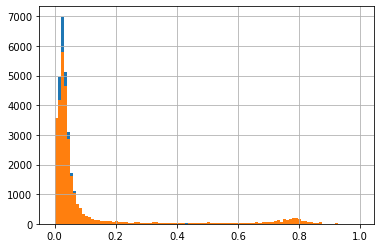

In [ ]:
df_val['upper_1'] = np.array(LengthUpperTransformer().transform(df_val['less_toxic']).todense()).reshape(-1,1)
df_val['upper_2'] = np.array(LengthUpperTransformer().transform(df_val['more_toxic']).todense()).reshape(-1,1)
print(df_val['upper_1'].mean(), df_val['upper_1'].std())
print(df_val['upper_2'].mean(), df_val['upper_2'].std())
df_val['upper_1'].hist(bins=100)
df_val['upper_2'].hist(bins=100)

In [ ]:
df_val['upper_1'].head(3)

0    0.026316
1    0.017167
2    0.041237
Name: upper_1, dtype: float64

## Train pipeline

- Load folds data
- train pipeline
- Predict on validation data
- Predict on test data

### Toxic data

In [ ]:
val_preds_arr1 = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2 = np.zeros((df_val.shape[0], n_folds))
test_preds_arr = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
    ])
    pipeline = Pipeline(
        [
            ("features", features),
            ("clf", LGBMRegressor()),
        ]
    )
    print("\nTrain:")
    pipeline.fit(df['text'], df['y'])
    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )
    # feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), np.round(pipeline['clf'].coef_,2) )), key = lambda x:x[1], reverse=True)    
    # pprint(feature_wts[:30])   
    
    print("\npredict validation data ")
    val_preds_arr1[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(16225, 2)

Train:

Total number of features: 104877

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(16225, 2)

Train:

Total number of features: 103920

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(16225, 2)

Train:

Total number of features: 104504

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(16225, 2)

Train:

Total number of features: 105496

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(16225, 2)

Train:

Total number of features: 103683

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(16225, 2)

Train:

Total number of features: 104443

predict

# Toxic __clean__ data

In [ ]:
val_preds_arr1c = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2c = np.zeros((df_val.shape[0], n_folds))
test_preds_arrc = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_clean_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),])
    pipeline = Pipeline(
        [
            ("features", features),           
            ("clf", LGBMRegressor()),
        ]
    )
    print("\nTrain:")
    pipeline.fit(df['text'], df['y'])
    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )
    # feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), np.round(pipeline['clf'].coef_,2) )), key = lambda x:x[1], reverse=True)
    # pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1c[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2c[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arrc[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(10709, 2)

Train:

Total number of features: 75032

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(10709, 2)

Train:

Total number of features: 74635

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(10709, 2)

Train:

Total number of features: 74452

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(10709, 2)

Train:

Total number of features: 75816

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(10709, 2)

Train:

Total number of features: 74327

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(10709, 2)

Train:

Total number of features: 75102

predict valid

## Ruddit data pipeline

In [ ]:
val_preds_arr1_ = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2_ = np.zeros((df_val.shape[0], n_folds))
test_preds_arr_ = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df2_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
    ])
    pipeline = Pipeline(
        [
            ("features", features),
            ("clf", LGBMRegressor()),
        ]
    )
    print("\nTrain:")    
    pipeline.fit(df['text'], df['y'])
    
    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )
    # feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), np.round(pipeline['clf'].coef_,2) )), key = lambda x:x[1], reverse=True)
    # pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1_[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2_[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr_[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(4087, 2)

Train:

Total number of features: 31907

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4087, 2)

Train:

Total number of features: 32306

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(4087, 2)

Train:

Total number of features: 31849

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(4087, 2)

Train:

Total number of features: 32452

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(4087, 2)

Train:

Total number of features: 32206

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(4087, 2)

Train:

Total number of features: 32242

predict validation 

In [ ]:
del df, pipeline # , feature_wts
gc.collect()

631

In [ ]:
print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')

 Toxic CLEAN data 
Validation Accuracy is 67.14


In [ ]:
print(" Toxic CLEAN data new ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')

 Toxic CLEAN data new 
Validation Accuracy is 67.14


# Validate the pipeline 

In [ ]:
print(" Toxic data ")
p1 = val_preds_arr1.mean(axis=1)
p2 = val_preds_arr2.mean(axis=1)

print(f'Validation Accuracy is { np.round((p1 < p2).mean() * 100,2)}')

print(" Ruddit data ")
p3 = val_preds_arr1_.mean(axis=1)
p4 = val_preds_arr2_.mean(axis=1)

print(f'Validation Accuracy is { np.round((p3 < p4).mean() * 100,2)}')

print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')

 Toxic data 
Validation Accuracy is 68.06
 Ruddit data 
Validation Accuracy is 61.81
 Toxic CLEAN data 
Validation Accuracy is 67.14


In [ ]:
print("Find right weight")

wts_acc = []
for i in range(30,70,1):
    for j in range(0,20,1):
        w1 = i/100
        w2 = (100 - i - j)/100
        w3 = (1 - w1 - w2 )
        p1_wt = w1*p1 + w2*p3 + w3*p5
        p2_wt = w1*p2 + w2*p4 + w3*p6
        wts_acc.append( (w1,w2,w3, np.round((p1_wt < p2_wt).mean() * 100,2)) )
sorted(wts_acc, key=lambda x:x[3], reverse=True)[:5]

Find right weight


[(0.69, 0.25, 0.06000000000000005, 68.21),
 (0.69, 0.24, 0.07000000000000006, 68.21),
 (0.68, 0.24, 0.07999999999999996, 68.2),
 (0.68, 0.26, 0.05999999999999994, 68.18),
 (0.68, 0.25, 0.06999999999999995, 68.18)]

In [ ]:
w1,w2,w3,_ = sorted(wts_acc, key=lambda x:x[2], reverse=True)[0]
p1_wt = w1*p1 + w2*p3 + w3*p5
p2_wt = w1*p2 + w2*p4 + w3*p6

## Analyze bad predictions 
### Incorrect predictions with similar scores
### Incorrect predictions with different scores

In [ ]:
df_val['p1'] = p1_wt
df_val['p2'] = p2_wt
df_val['diff'] = np.abs(p2_wt - p1_wt)
df_val['correct'] = (p1_wt < p2_wt).astype('int')

In [ ]:
df_val[df_val.correct == 0].sort_values('diff', ascending=True).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
12713,666,"BNP talk page\n\nI am deleting my OWN posted sections and posts. I can only presume you are not familiar with wikipedia ruler, whatever the case you made a foolish post on my page. Please do not waste my time and read wikipedia rules before making other mistakes. Thanks.","""Referring to the innermost deeply held spiritual / philosophical beliefs of other people as """"crap"""" is what is unacceptable! \n\n""",0.036765,0.007519,0.198787,0.198784,0.000003,0
12714,675,"BNP talk page\n\nI am deleting my OWN posted sections and posts. I can only presume you are not familiar with wikipedia ruler, whatever the case you made a foolish post on my page. Please do not waste my time and read wikipedia rules before making other mistakes. Thanks.","""Referring to the innermost deeply held spiritual / philosophical beliefs of other people as """"crap"""" is what is unacceptable! \n\n""",0.036765,0.007519,0.198787,0.198784,0.000003,0
12715,665,"BNP talk page\n\nI am deleting my OWN posted sections and posts. I can only presume you are not familiar with wikipedia ruler, whatever the case you made a foolish post on my page. Please do not waste my time and read wikipedia rules before making other mistakes. Thanks.","""Referring to the innermost deeply held spiritual / philosophical beliefs of other people as """"crap"""" is what is unacceptable! \n\n""",0.036765,0.007519,0.198787,0.198784,0.000003,0
1826,72,Do tacos really give you diarhea like your vandalism said?,"omp rice \n\nomp way to not answer. I apologized for the 'dar dar dar' thing and I ask nicely why you are willing to permit a page about a frickin' spaghetti monster and yet not Penelopism, an actual belief system and you don't frickin' answer. Honestly. Do you believe in this spaghetti monster...",0.017241,0.025586,0.261391,0.261378,0.000013,0
1825,548,Do tacos really give you diarhea like your vandalism said?,"omp rice \n\nomp way to not answer. I apologized for the 'dar dar dar' thing and I ask nicely why you are willing to permit a page about a frickin' spaghetti monster and yet not Penelopism, an actual belief system and you don't frickin' answer. Honestly. Do you believe in this spaghetti monster...",0.017241,0.025586,0.261391,0.261378,0.000013,0
1824,465,Do tacos really give you diarhea like your vandalism said?,"omp rice \n\nomp way to not answer. I apologized for the 'dar dar dar' thing and I ask nicely why you are willing to permit a page about a frickin' spaghetti monster and yet not Penelopism, an actual belief system and you don't frickin' answer. Honestly. Do you believe in this spaghetti monster...",0.017241,0.025586,0.261391,0.261378,0.000013,0
27581,737,my question is: why this guy has not yet banned? Other old vandalism,"""\n\n Edit Warning \n\nPlease refrain from abusive behaviour and making edits to the talk pages of other users. It creates a rather negative atmosphere on Wikipedia and will not be tolerated. Troll elsewhere. — Preceding unsigned comment added by 193.40.56.38 \n\nYou have been behaving in an ...",0.014286,0.023310,0.171361,0.171347,0.000014,0
27582,231,my question is: why this guy has not yet banned? Other old vandalism,"""\n\n Edit Warning \n\nPlease refrain from abusive behaviour and making edits to the talk pages of other users. It creates a rather negative atmosphere on Wikipedia and will not be tolerated. Troll elsewhere. — Preceding unsigned comment added by 193.40.56.38 \n\nYou have been behaving in an ...",0.014286,0.023310,0.171361,0.171347,0.000014,0
2309,633,"""\nNoting that it was hardly """"vandalism."""" Any psuedo-intellectual can pretend he's some sort of PhD online and somehow use that to justify walls of ridiculous text. Not that you aren't a PhD, of course, but you can see how easy it would be to make something like that up. Also, this isn't a """"T...",yes i do bealvie your claims of me being cool but nop that is not what started this this is a new issu

#### Some of these just look incorrectly tagged 


In [ ]:
df_val[df_val.correct == 0].sort_values('diff', ascending=False).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
25062,246,CaliforniaAliBaba is a Bitch\nGo fuck yourself you bitch ass motherfucker. Don't you ever in your fucking life threatening me you fucking piece of shit you. You don't know me I will fucking kill your ass you punk pussy bitch. tell your mama to my black dick.,I've heard a snippet on their myspace page but I'm afraid I haven't given them much though musically as of yet. Perhaps I will be purchasing one of their albums since I seem to spend about a third of my time on wiki reverting their vandalism.,0.031128,0.024390,0.801961,0.178237,0.623724,0
13944,106,"Hey \n\nhey faggot, are you dead yet? or are you watching your mom getting raped by filthy pigs? which one is it? I'm coming to rape your mom and shoot your entire family. You have 1 week to live, you motherfucker.",)\n\nNo images\n\n(vote here to remove all poo pix,0.014085,0.021739,0.795033,0.178120,0.616913,0
7788,580,suck my dick \n\nfuck you dirty whore bitch,Stop being such a sissy.,0.000000,0.040000,0.799854,0.198512,0.601341,0
28241,118,you are a stupid fuck \n\nand your mother's cunt stinks,"""\n\n ::: According to Stratfordian authority H.N.Gibson(frequently cited in this very article) the controversy began with John Marston and Joseph Hall in 1597 which view was even more fully affirmed by Stratfordian authorities Garnett and Gosse over fifty years previously. According to Strat...",0.000000,0.033095,0.757164,0.180290,0.576874,0
22659,386,"YOU SUCK \n\nI HATE YOU> YOU CAN FUCK MY ASS ALL NIGHT BITCH SHit\n\nLove , David Ortiz","""\n\n Antony and the Johnsons \n\nWell, Cardinal, is """"Antony's voice seems to channel Nina Simone and Bryan Ferry, and he has many celebrity admirers such as Philip Glass, Marc Almond, Lou Reed and the guest vocalists on I Am a Bird Now, Boy George, Rufus Wainwright and Devendra Banhart"""" an op...",0.571429,0.054545,0.775799,0.199293,0.576505,0
10376,88,Yo Wuhwuzdat u a bitch wit no life. Yeah u heard me u a bitch. fuck u motherfucka,"""\n\n Name \n\nPaper Wrapped Cake? That is lame. That's not even its proper name! How about sponge cake? — ¡ρρ¡ ¡ρρ¡ """,0.037037,0.059829,0.716719,0.144328,0.572391,0
16261,235,"Last Warning \n\nOnce again, don't give a fuck mr dumbass.\n\nseriously, you people who eidt these wiki pages are fucking whores. i saw att he top of the page where it says if it is presented politely you'll look at it and change it if correct, well, maybe you wouldn't have to do that if you ju...","p.s.\nwikipedia is not for freedom of speech or for reliable sources. its for a bunch of jack asses who wanna feel important by imposing rules on everyone. wikipedia is about as reliable as a gossip mag. i don't care what that guy says, chinese democracy was recorde from 1997 to 2007 not 1994. h...",0.004484,0.000000,0.762587,0.199919,0.562668,0
2077,141,you are a fucking bawbag.\n\nget a real job you bumder and stop moaning to wikipedia you sack of spunk.\n\nim going to come to your house and rape your children.,Who cares anymore. They attack with impunity.,0.000000,0.042553,0.736841,0.186234,0.550607,0
25754,190,what the hell man? why did you delete my page (savannah hoard) screw you dude\n\ni mean really? if you're not gonna let me have a page then you can go fuck your fat self you 40 year old bitch\n\nyour a total bitch who goes around deleting people's pages you fucking disgust me im gonna kick your ...,""" December 2009 (UTC)\n\n Now there's typical AGW alarmist Watermelon argumentum ad hominem content-vacant suppressive authoritarian WikiNazi rottenness if ever it got posted online. Don't address Monckton's (or Nsaa's) position, but strive (with utter ineffectiveness, I might add) to fault the ...",0.000000,0.039146,0.756355,0.210461,0.545894,0
1952,431,ASSHOLES! COME AND TRY ME YOU STUPID FUCK SON OF A BITCHES!!!!,"""\n\nPlease, Cheesebot is not nonsense. It is a formidible and tangible thing, can you please not delete this page again? I don't believe yo

# Predict on test data 

In [ ]:
df_sub['score'] = w1*test_preds_arr.mean(axis=1) + w2*test_preds_arr_.mean(axis=1) + w3*test_preds_arrc.mean(axis=1)

## Correct the rank ordering

In [ ]:
df_sub['score'].count() - df_sub['score'].nunique()

16

In [ ]:
same_score = df_sub['score'].value_counts().reset_index()[:10]
same_score

,index,score
0,0.711423,3
1,0.555074,2
2,0.239122,2
3,0.173088,2
4,0.303004,2
5,0.300849,2
6,0.245834,2
7,0.278097,2
8,0.243434,2
9,0.277588,2


In [ ]:
df_sub[df_sub['score'].isin(same_score['index'].tolist())]

,comment_id,text,score
1832,95080362,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.173088
2842,160935265,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.173088
4757,270227263,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.711423
4758,270227418,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.711423
4759,270227815,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.711423
5743,339264823,You are 22 years older than your husband! You are an old cougar! \n\nYou are an old cougar! You are an old cougar!,0.245834
5744,339265390,You are 22 years older than your husband! You are an old cougar! \n\nYou are an old cougar! You are an old cougar!,0.245834
5752,339478276,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.303004
5753,339478966,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.303004
5832,345043812,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.300849


# Bert Ensemble

In [ ]:
%%time

import os
import gc
import cv2
import copy
import time
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 42,
    model_name = '../input/roberta-base',
    test_batch_size = 64,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

MODEL_PATHS = [
    '../input/pytorch-w-b-jigsaw-starter/Loss-Fold-0.bin',
    '../input/pytorch-w-b-jigsaw-starter/Loss-Fold-1.bin',
    '../input/pytorch-w-b-jigsaw-starter/Loss-Fold-2.bin',
    '../input/pytorch-w-b-jigsaw-starter/Loss-Fold-3.bin',
    '../input/pytorch-w-b-jigsaw-starter/Loss-Fold-4.bin'
]

def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS


def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    return final_preds


set_seed(CONFIG['seed'])
df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df.head()

test_dataset = JigsawDataset(df, CONFIG['tokenizer'], max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'], num_workers=2, shuffle=False, pin_memory=True)
preds1 = inference(MODEL_PATHS, test_loader, CONFIG['device'])

Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 1


100%|██████████| 118/118 [00:31<00:00,  3.79it/s]
Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 2


100%|██████████| 118/118 [00:30<00:00,  3.91it/s]
Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 3


100%|██████████| 118/118 [00:30<00:00,  3.91it/s]
Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 4


100%|██████████| 118/118 [00:30<00:00,  3.91it/s]
Some weights of the model checkpoint at ../input/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Getting predictions for model 5


100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


CPU times: user 2min 40s, sys: 6.07 s, total: 2min 46s
Wall time: 3min 29s


In [ ]:
preds = (preds1-preds1.min())/(preds1.max()-preds1.min())

In [ ]:
df_sub['score'] = df_sub['score']*0.85+preds*0.15

In [ ]:
df_sub[['comment_id', 'score']].to_csv("submission.csv", index=False)